In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neural_network import MLPClassifier
from graphviz import Source
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
from IPython.display import SVG
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

**EDA and Proprocessing**

In [2]:
df = pd.read_csv('crop_data.csv') #https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-datase
df = df.dropna()
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


<Axes: >

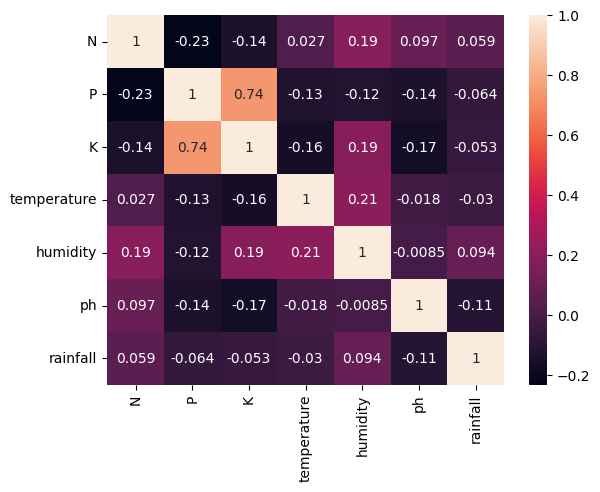

In [3]:
correlation = df.corr()
sns.heatmap(correlation, annot=True)

In [4]:
#Removing K column as P and K are highly correlated
df = df.drop("K", axis=1)
display(df.label.unique())

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [5]:
def get_crop_category(crop_name):
    cereal_crops = ['rice', 'maize']
    pulse_crops = ['chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'blackgram', 'lentil']
    fruit_crops = ['pomegranate', 'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya', 'coconut']
    fiber_cash_crops = ['cotton', 'jute', 'coffee']  
    if crop_name.lower() in cereal_crops:
        return '0'
    elif crop_name.lower() in pulse_crops:
        return '1'
    elif crop_name.lower() in fruit_crops:
        return '2'
    elif crop_name.lower() in fiber_cash_crops:
        return '3'
    else:
        return '4'   
df['label'] = df['label'].apply(get_crop_category)
display(df.label.unique())

array(['0', '1', '2', '3'], dtype=object)

In [6]:
#Final Dataset after preprocessing
scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
df

,N,P,temperature,humidity,ph,rainfall,label
0,1.068797,-0.344551,-0.935587,0.472666,0.043302,1.810361,0
1,0.933329,0.140616,-0.759646,0.397051,0.734873,2.242058,0
2,0.255986,0.049647,-0.515898,0.486954,1.771510,2.921066,0
3,0.635298,-0.556811,0.172807,0.389805,0.660308,2.537048,0
4,0.743673,-0.344551,-1.083647,0.454792,1.497868,2.898373,0
...,...,...,...,...,...,...,...
2195,1.529390,-0.587134,0.228814,-0.227709,0.401395,1.352437,3
2196,1.312641,-1.163269,0.355720,-0.666947,-0.494413,0.445183,3
2197,1.827421,-0.617457,-0.293218,-0.191235,-0.138120,1.271418,3
2198,1.800327,-0.647780,0.129612,-0.869518,0.373904,0.431545,3


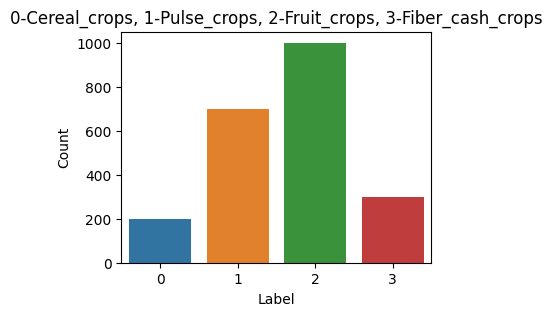

In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x = "label", data=df)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("0-Cereal_crops, 1-Pulse_crops, 2-Fruit_crops, 3-Fiber_cash_crops")
plt.show()

In [8]:
feature_cols = ['N', 'P', 'temperature', 'humidity', 'ph', 'rainfall']
X = df.drop("label", axis=1)
y = df.label
display(X.head())
display(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

,N,P,temperature,humidity,ph,rainfall
0,1.068797,-0.344551,-0.935587,0.472666,0.043302,1.810361
1,0.933329,0.140616,-0.759646,0.397051,0.734873,2.242058
2,0.255986,0.049647,-0.515898,0.486954,1.771510,2.921066
3,0.635298,-0.556811,0.172807,0.389805,0.660308,2.537048
4,0.743673,-0.344551,-1.083647,0.454792,1.497868,2.898373


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: object

**Decision Tree**

In [9]:
#Different Depths with cross-validation
def dt(df):
    depths = [1, 3, 5, 7, 10, 15, 25, 35, 50, 75, 100]
    results = []
    for d in depths:
        clf = tree.DecisionTreeClassifier(max_depth=d, random_state=1)
        scores = cross_val_score(clf, X, y, cv=5)
        mean_score = scores.mean()
        results.append((d, mean_score)) 
    res_df = pd.DataFrame(results, columns=['Depth', 'Avg_Cross_Acc'])
    return res_df
dt_res = dt(df)
dt_res

,Depth,Avg_Cross_Acc
0,1,0.611818
1,3,0.585909
2,5,0.621364
3,7,0.686818
4,10,0.690000
5,15,0.690909
6,25,0.690909
7,35,0.690909
8,50,0.690909
9,75,0.690909


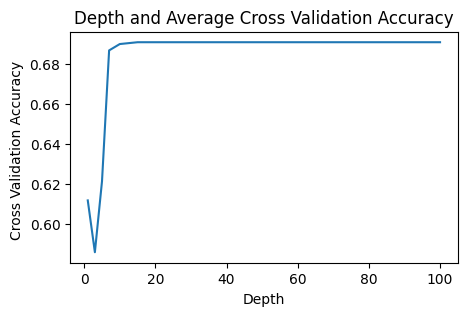

In [10]:
plt.figure(figsize = (5,3))
sns.lineplot(data=dt_res, x='Depth', y='Avg_Cross_Acc')
plt.title('Depth and Average Cross Validation Accuracy')
plt.xlabel('Depth')
plt.ylabel('Cross Validation Accuracy ')
plt.show()

In [11]:
treeclf = DecisionTreeClassifier(max_depth=1, random_state=1)
treeclf.fit(X_train, y_train)
y_pred = treeclf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.66      0.83      0.74       142
           2       0.70      0.92      0.80       201
           3       0.00      0.00      0.00        64

    accuracy                           0.69       440
   macro avg       0.34      0.44      0.38       440
weighted avg       0.53      0.69      0.60       440

[[  0  20  13   0]
 [  0 118  24   0]
 [  0  17 184   0]
 [  0  24  40   0]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


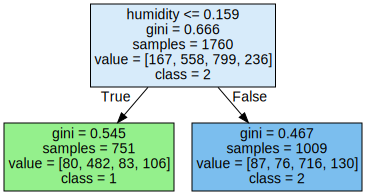

In [12]:
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True))
display(SVG(graph.pipe(format='svg')))

In [13]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,N,0.0
1,P,0.0
2,temperature,0.0
3,humidity,1.0
4,ph,0.0
5,rainfall,0.0


In [14]:
treeclf = DecisionTreeClassifier(max_depth=9, random_state=1)
treeclf.fit(X_train, y_train)
y_pred = treeclf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      1.00      1.00       142
           2       1.00      1.00      1.00       201
           3       1.00      0.97      0.98        64

    accuracy                           1.00       440
   macro avg       0.99      0.99      0.99       440
weighted avg       1.00      1.00      1.00       440

[[ 33   0   0   0]
 [  0 142   0   0]
 [  0   0 201   0]
 [  2   0   0  62]]


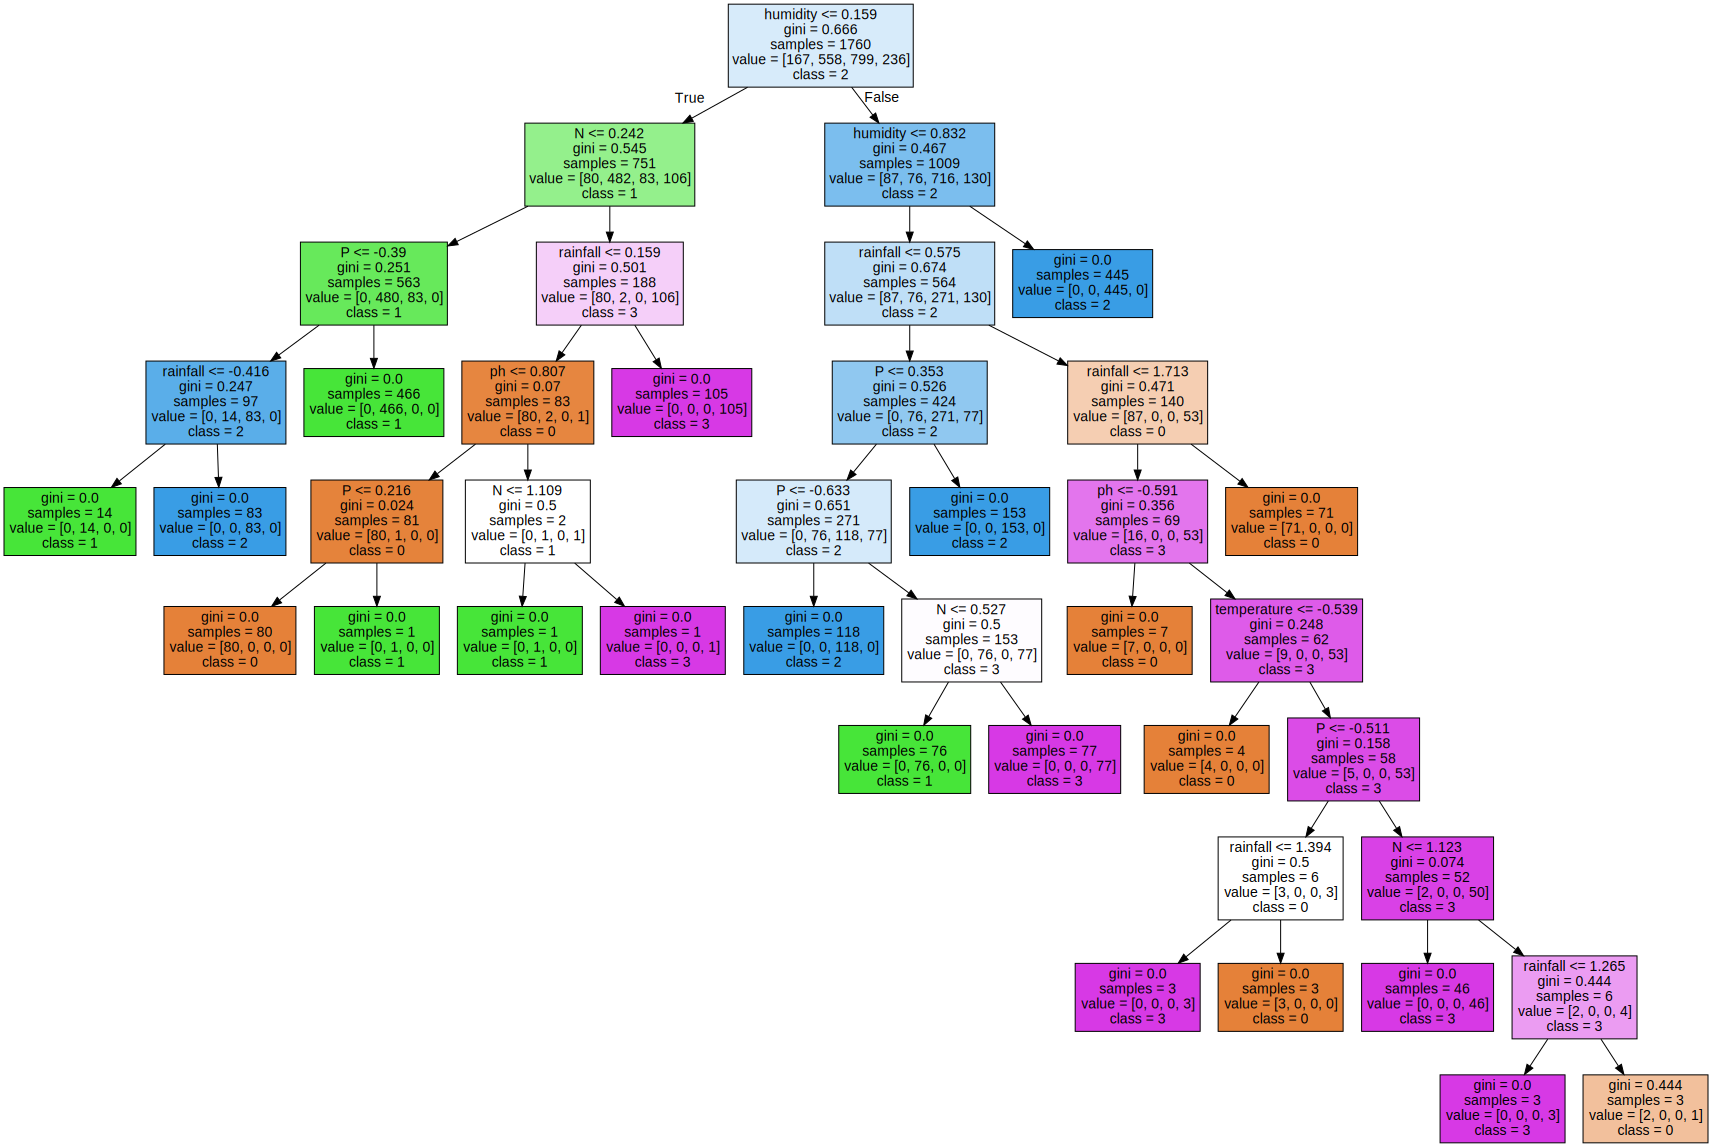

In [15]:
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True))
display(SVG(graph.pipe(format='svg')))

In [16]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,N,0.215076
1,P,0.229206
2,temperature,0.005334
3,humidity,0.327535
4,ph,0.010284
5,rainfall,0.212564


[0.6806818181818182, 0.7397727272727272, 0.8732954545454545, 0.9028409090909091, 0.9517045454545454, 0.9971590909090909, 0.9971590909090909, 0.9988636363636364, 0.9994318181818181, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6863636363636364, 0.7386363636363636, 0.8409090909090909, 0.8886363636363637, 0.9431818181818182, 0.9977272727272727, 0.9977272727272727, 0.9977272727272727, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455, 0.9954545454545455]


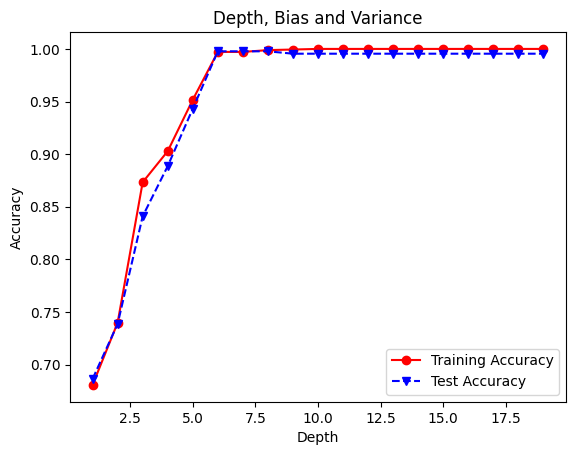

In [17]:
maxdepths = range(1, 20)
trainAcc = []
testAcc = []
for maxdepth in maxdepths:
    treeclf = DecisionTreeClassifier(max_depth=maxdepth, random_state=1)
    treeclf.fit(X_train, y_train)
    trainAcc.append(accuracy_score(y_train, treeclf.predict(X_train)))
    testAcc.append(accuracy_score(y_test, treeclf.predict(X_test)))
print(trainAcc)
print(testAcc)    
plt.plot(maxdepths, trainAcc, 'ro-', maxdepths, testAcc, 'bv--')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Depth, Bias and Variance')
plt.show()

**Neural Network**

In [18]:
import networkx as nx
import colorsys
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])
    G = nx.DiGraph()
    pos = {}
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)
    for j in range(hidden_layers_n):
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)
    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]
    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)

[[ 15   1   4  13]
 [  1 127  14   0]
 [  1  14 181   5]
 [  8   0   4  52]]
              precision    recall  f1-score   support

           0       0.60      0.45      0.52        33
           1       0.89      0.89      0.89       142
           2       0.89      0.90      0.90       201
           3       0.74      0.81      0.78        64

    accuracy                           0.85       440
   macro avg       0.78      0.77      0.77       440
weighted avg       0.85      0.85      0.85       440



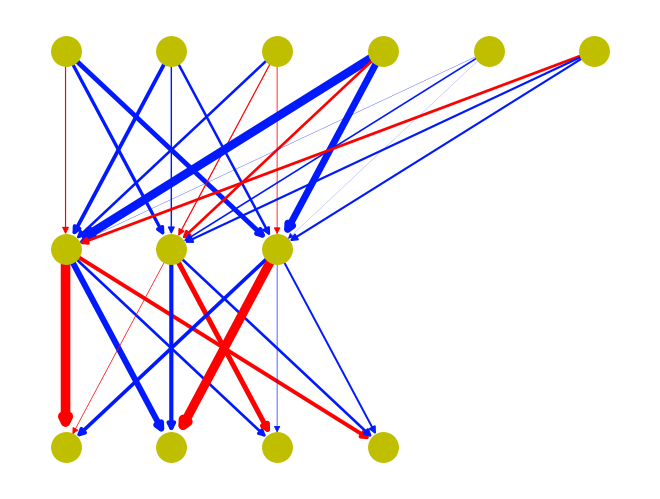

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(3),max_iter=5000)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
show_ann(mlp)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[ 21   1   0  11]
 [  0 141   1   0]
 [  3   4 193   1]
 [  9   0   1  54]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        33
           1       0.97      0.99      0.98       142
           2       0.99      0.96      0.97       201
           3       0.82      0.84      0.83        64

    accuracy                           0.93       440
   macro avg       0.85      0.86      0.86       440
weighted avg       0.93      0.93      0.93       440



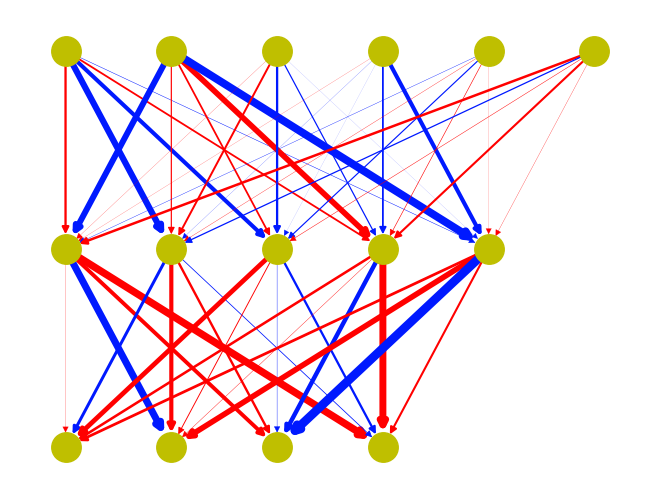

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(5),max_iter=500)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
show_ann(mlp)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[ 30   0   0   3]
 [  0 142   0   0]
 [  2   1 198   0]
 [  2   0   3  59]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.99      1.00      1.00       142
           2       0.99      0.99      0.99       201
           3       0.95      0.92      0.94        64

    accuracy                           0.97       440
   macro avg       0.95      0.95      0.95       440
weighted avg       0.98      0.97      0.97       440



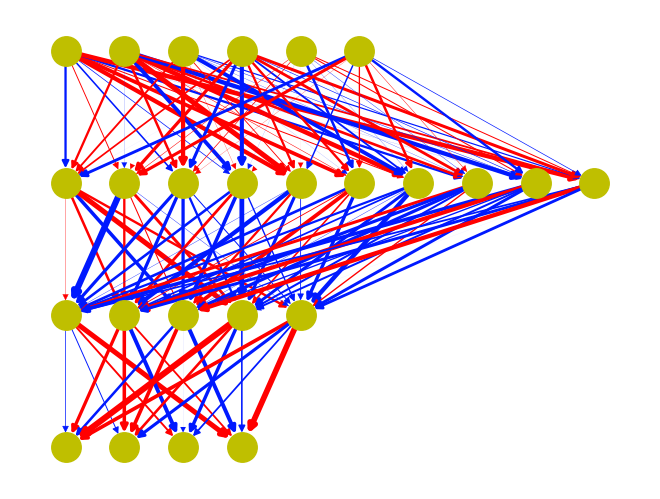

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 5),max_iter=500)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
show_ann(mlp)

In [22]:
print('This dataset has {} input nodes and {} output node(s)'.format(len(X.columns), len(y.unique())))
print('There are {} 2D arrays of coefficients, one for each layer'.format(len(mlp.coefs_)))
print('The layers have the following number of coefficients: {}')
for l in range(len(mlp.coefs_)):
    m = len(mlp.coefs_[l])
    n = len(mlp.coefs_[l][0])
    print('  {}: {}x{} ({} nodes feeding into a layer of {} nodes)'.format(l, m, n, m, n))
print()
print('There are {} 1D arrays of intercepts, one for each layer'.format(len(mlp.intercepts_)))
print('Each layer has {} intercepts, one for each node'.format([len(mlp.intercepts_[l]) for l,_ in enumerate(mlp.intercepts_)]))

This dataset has 6 input nodes and 4 output node(s)
There are 3 2D arrays of coefficients, one for each layer
The layers have the following number of coefficients: {}
  0: 6x10 (6 nodes feeding into a layer of 10 nodes)
  1: 10x5 (10 nodes feeding into a layer of 5 nodes)
  2: 5x4 (5 nodes feeding into a layer of 4 nodes)

There are 3 1D arrays of intercepts, one for each layer
Each layer has [10, 5, 4] intercepts, one for each node
